## Modeling for predicting critical outcome at ED disposition

Work Flow:
1. Task-specific filter
2. Variable selection
3. Modeling script
4. Performance output


### Load train and test

In [1]:
import os
import time
import random
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import load_model
from helpers import PlotROCCurve, get_lstm_data_gen
from dataset_path import output_path

path = output_path
output_path = os.path.join(path, "Figure3")
df_train = pd.read_csv((os.path.join(path, 'train.csv')))
df_test = pd.read_csv((os.path.join(path, 'test.csv')))
confidence_interval = 95
random_seed=0


In [ ]:
os.environ['TF_DETERMINISTIC_OPS'] = '1'
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

In [2]:
pd.set_option('display.max_columns', 100) 
pd.set_option('display.max_rows', 100) 

df_train.head()

index  subject_id     hadm_id   stay_id               intime  \
0  394512    10509415         NaN  39157213  2178-11-07 21:01:00   
1  163920    19402485  27265022.0  35695207  2149-04-10 22:36:00   
2  235492    12126972  21011915.0  33586273  2110-03-31 10:59:00   
3   43991    17759885         NaN  31346320  2155-01-03 09:43:00   
4  291495    12197131  26028634.0  34998956  2123-07-30 11:41:00   

               outtime  anchor_age gender  anchor_year  dod  \
0  2178-11-07 21:26:00          45      M         2173  NaN   
1  2149-04-11 00:47:05          55      M         2149  NaN   
2  2110-03-31 15:33:00          65      F         2110  NaN   
3  2155-01-03 09:54:00          63      F         2154  NaN   
4  2123-07-30 23:24:00          60      M         2123  NaN   

             admittime            dischtime deathtime               ethnicity  \
0                  NaN                  NaN       NaN                   OTHER   
1  2149-04-11 00:46:00  2149-04-12 15:00:00       NaN  BLACK/AFRICAN AMERICAN   
2  2110-03-31 14:50:00  2110-04-02 13:40:00       NaN                   WHITE   
3                  NaN                  NaN       NaN                     NaN   
4  2123-07-30 17:24:00  2123-08-08 13:02:00       NaN                   OTHER   

             edregtime            edouttime insurance  in_year  age  \
0                  NaN                  NaN       NaN     2178   50   
1  2149-04-10 22:36:00  2149-04-11 03:20:00     Other     2149   55   
2  2110-03-31 10:59:00  2110-03-31 15:33:00     Other     2110   65   
3                  NaN                  NaN       NaN     2155   64   
4  2123-07-30 11:41:00  2123-07-30 23:24:00  Medicaid     2123   60   

   outcome_inhospital_mortality  ed_death  before_ed_mortality  \
0                         False     False                False   
1                         False     False                False   
2                         False     False                False   
3                         False     False                False   
4                         False     False                False   

            ed_los intime_icu time_to_icu_transfer  outcome_icu_transfer_12h  \
0  0 days 00:25:00        NaN                  NaN                     False   
1  0 days 02:11:05        NaN                  NaN                     False   
2  0 days 04:34:00        NaN                  NaN                     False   
3  0 days 00:11:00        NaN                  NaN                     False   
4  0 days 11:43:00        NaN                  NaN                     False   

   outcome_hospitalization  outcome_critical  n_ed_30d  n_ed_90d  n_ed_365d  \
0                    False             False         0         0          0   
1                     True             False         0         0          0   
2                     True             False         0         0          0   
3                    False             False         0         1          1   
4                     True             False         0         0          0   

    next_ed_visit_time next_ed_visit_time_diff  outcome_ed_revisit_3d  \
0  2178-11-09 10:37:00         1 days 13:11:00                   True   
1                  NaN                     NaN                  False   
2                  NaN                     NaN                  False   
3  2155-02-10 12:49:00        38 days 02:55:00                  False   
4  2125-08-30 20:50:00       761 days 21:26:00                  False   

   n_hosp_30d  n_hosp_90d  n_hosp_365d  n_icu_30d  n_icu_90d  n_icu_365d  \
0           0           0            0          0          0           0   
1           0           0            0          0          0           0   
2           0           0            0          0          0           0   
3           0           0            0          0          0           0   
4           0           0            0          0          0           0   

   ed_los_hours  time_to_icu_transfer_hours  next_ed_

### 1. task-specific filter

In [3]:
df_train = df_train[(df_train['before_ed_mortality'] == False) & (df_train['ed_death'] == False)]
df_test = df_test[(df_test['before_ed_mortality'] == False) & (df_test['ed_death'] == False)]

### 2. Variable Selection

In [4]:
variable = ["age", "gender", 
            
            "n_ed_30d", "n_ed_90d", "n_ed_365d", "n_hosp_30d", "n_hosp_90d", 
            "n_hosp_365d", "n_icu_30d", "n_icu_90d", "n_icu_365d", 
            
            "triage_pain", "triage_acuity",
            
            "chiefcom_chest_pain", "chiefcom_abdominal_pain", "chiefcom_headache", 
            "chiefcom_shortness_of_breath", "chiefcom_back_pain", "chiefcom_cough", 
            "chiefcom_nausea_vomiting", "chiefcom_fever_chills", "chiefcom_syncope",
            "chiefcom_dizziness",
            
            "cci_MI", "cci_CHF", "cci_PVD", "cci_Stroke", "cci_Dementia", "cci_Pulmonary", 
            "cci_Rheumatic", "cci_PUD", "cci_Liver1", "cci_DM1", "cci_DM2", 
            "cci_Paralysis", "cci_Renal", "cci_Cancer1", "cci_Liver2", "cci_Cancer2", 
            "cci_HIV",
            
            "eci_Arrhythmia", "eci_Valvular", "eci_PHTN",  "eci_HTN1", "eci_HTN2",  
            "eci_NeuroOther", "eci_Hypothyroid", "eci_Lymphoma", "eci_Coagulopathy", 
            "eci_Obesity", "eci_WeightLoss", "eci_FluidsLytes", "eci_BloodLoss", 
            "eci_Anemia", "eci_Alcohol", "eci_Drugs", "eci_Psychoses", "eci_Depression",
            
            "ed_temperature_last", "ed_heartrate_last", "ed_resprate_last", 
            "ed_o2sat_last", "ed_sbp_last", "ed_dbp_last", "ed_los", "n_med", "n_medrecon"]

outcome = "outcome_critical"

In [5]:
X_train = df_train[variable].copy()
y_train = df_train[outcome].copy()
X_test = df_test[variable].copy()
y_test = df_test[outcome].copy()

In [6]:
X_train.dtypes.to_frame().T

age  gender n_ed_30d n_ed_90d n_ed_365d n_hosp_30d n_hosp_90d  \
0  int64  object    int64    int64     int64      int64      int64   

  n_hosp_365d n_icu_30d n_icu_90d n_icu_365d triage_pain triage_acuity  \
0       int64     int64     int64      int64     float64       float64   

  chiefcom_chest_pain chiefcom_abdominal_pain chiefcom_headache  \
0                bool                    bool              bool   

  chiefcom_shortness_of_breath chiefcom_back_pain chiefcom_cough  \
0                         bool               bool           bool   

  chiefcom_nausea_vomiting chiefcom_fever_chills chiefcom_syncope  \
0                     bool                  bool             bool   

  chiefcom_dizziness cci_MI cci_CHF cci_PVD cci_Stroke cci_Dementia  \
0               bool  int64   int64   int64      int64        int64   

  cci_Pulmonary cci_Rheumatic cci_PUD cci_Liver1 cci_DM1 cci_DM2  \
0         int64         int64   int64      int64   int64   int64   

  cci_Paralysis cci_Renal cci_Cancer1 cci_Liver2 cci_Cancer2 cci_HIV  \
0         int64     int64       int64      int64       int64   int64   

  eci_Arrhythmia eci_Valvular eci_PHTN eci_HTN1 eci_HTN2 eci_NeuroOther  \
0          int64        int64    int64    int64    int64          int64   

  eci_Hypothyroid eci_Lymphoma eci_Coagulopathy eci_Obesity eci_WeightLoss  \
0           int64        int64            int64       int64          int64   

  eci_FluidsLytes eci_BloodLoss eci_Anemia eci_Alcohol eci_Drugs  \
0           int64         int64      int64       int64     int64   

  eci_Psychoses eci_Depression ed_temperature_last ed_heartrate_last  \
0         int64          int64             float64           float64   

  ed_resprate_last ed_o2sat_last ed_sbp_last ed_dbp_last  ed_los    n_med  \
0          float64       float64     float64     float64  object  float64   

  n_medrecon  
0    float64

In [7]:
encoder = LabelEncoder()
X_train['gender'] = encoder.fit_transform(X_train['gender'])
X_test['gender'] = encoder.transform(X_test['gender'])

In [8]:
X_train['ed_los'] = pd.to_timedelta(X_train['ed_los']).dt.seconds / 60
X_test['ed_los'] = pd.to_timedelta(X_test['ed_los']).dt.seconds / 60

In [9]:
print('class ratio')
print('positiave : negative =', y_train.sum()/(~y_train).sum(), ': 1')

class ratio
positiave : negative = 0.06329639889196675 : 1


### 3.  Modeling script

In [10]:
# Containers for all results
result_list = []

Logistic Regression:


/home/jun/virtualenvs/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training time: 7.795193433761597 seconds
AUC: 0.8569224774565216
AUPRC: 0.34635282209273055
Sensitivity: 0.7754543677936291
Specificity: 0.7799006817607945
Score thresold: 0.059207966719959565
2.5 97.5


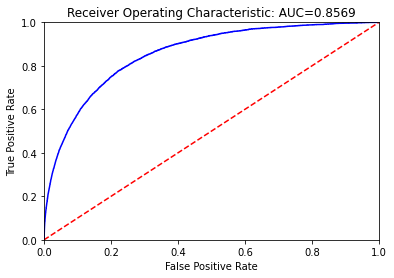

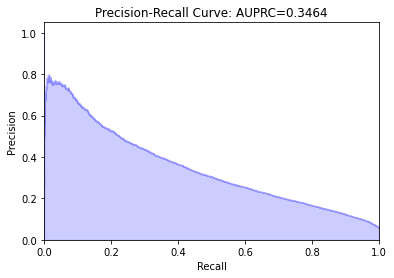

In [11]:
print("Logistic Regression:")
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression(random_state=random_seed)
start = time.time()
logreg.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = logreg.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["LR"]
results.extend(result)
results.append(runtime)
result_list.append(results)



RandomForest:
Training time: 52.04578518867493 seconds
AUC: 0.932241932540501
AUPRC: 0.5672334748228505
Sensitivity: 0.8759038499120578
Specificity: 0.8306780333545758
Score thresold: 0.09
2.5 97.5


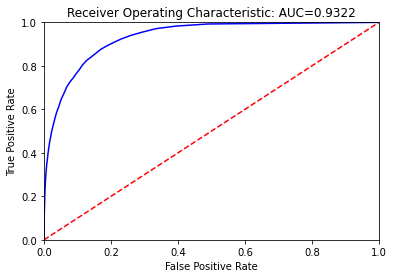

[0.06194942 0.01057169 0.00477951 0.00765101 0.01358096 0.00471013
 0.00753312 0.01257884 0.0026907  0.00568085 0.00915675 0.03441555
 0.07991361 0.00466595 0.00439468 0.00330478 0.00093767 0.00140143
 0.00182567 0.00188772 0.00357672 0.00226842 0.00218816 0.00351878
 0.00443034 0.00345562 0.00360654 0.00206076 0.00496572 0.00182979
 0.00198277 0.00344736 0.00505247 0.003365   0.00191046 0.00389678
 0.00393644 0.0021495  0.00273652 0.00079561 0.00508153 0.00344544
 0.00320145 0.0038354  0.00640962 0.00395028 0.00378214 0.00135318
 0.00404565 0.00384169 0.00329186 0.00504891 0.00165625 0.00311733
 0.00335045 0.00260432 0.00177837 0.00462036 0.05581486 0.08256951
 0.07857293 0.03509305 0.06856618 0.05743005 0.1240085  0.05282574
 0.04590115]


In [12]:
print("RandomForest:")
from sklearn.ensemble import RandomForestClassifier
rf= RandomForestClassifier(random_state=random_seed)
start = time.time()
rf.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = rf.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)
importances = rf.feature_importances_
print(importances)

results = ["RF"]
results.extend(result)
results.append(runtime)
result_list.append(results)

GradientBoosting:
Training time: 78.79736661911011 seconds
AUC: 0.9335598623271044
AUPRC: 0.5544319386010637
Sensitivity: 0.8559702950947821
Specificity: 0.8495196412038428
Score thresold: 0.07718714501377986
2.5 97.5


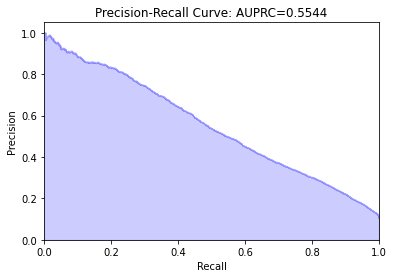

In [13]:
print("GradientBoosting:")
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=random_seed)
start = time.time()
gb.fit(X_train, y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = gb.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["GB"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [29]:
class MLP(tf.keras.Model):
    def __init__(self):
        super(MLP, self).__init__()
        self.dense_1 = Dense(128, activation='relu')
        self.dense_2 = Dense(64, activation='relu')
        self.classifier = Dense(1, activation='sigmoid')

    def call(self, x):
        x = self.dense_1(x)
        x = self.dense_2(x)
        return self.classifier(x)

In [32]:
# skip this cell if not retraining
mlp = MLP()
mlp.compile(loss='binary_crossentropy', 
              optimizer=optimizers.Adam(learning_rate=0.001), 
              metrics=['accuracy', 'AUC', {'auprc': metrics.AUC(name='auprc', curve='PR')}, 
                       'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
start = time.time()
mlp.fit(X_train.astype(np.float32), y_train, batch_size=200, epochs=20)
runtime = time.time() - start
print('Training time:', runtime, 'seconds')
mlp.save('critical_disposition_mlp')

2022-01-14 17:04:43.291247: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Training time: 3.337860107421875e-05 seconds
INFO:tensorflow:Assets written to: critical_disposition_mlp/assets


INFO:tensorflow:Assets written to: critical_disposition_mlp/assets


MLP:


2022-01-14 17:08:28.757894: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-14 17:08:30.507751: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18197 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:17:00.0, compute capability: 8.6
2022-01-14 17:08:30.508683: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 18865 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6
2022-01-14 17:08:32.225717: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix 

AUC: 0.9371805561070112
AUPRC: 0.5573905209271602
Sensitivity: 0.8776626929841704
Specificity: 0.8385417292916661
Score thresold: 0.059016857
2.5 97.5


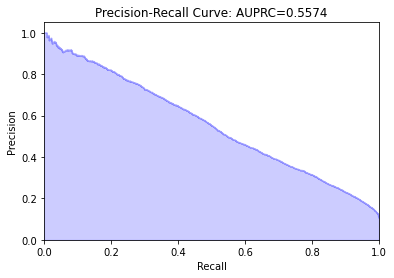

In [14]:
print("MLP:")
mlp = load_model('critical_disposition_mlp')
probs = mlp.predict(X_test.astype(np.float32))
result = PlotROCCurve(probs, y_test, ci=confidence_interval, random_seed=random_seed)
results = ["MLP"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [15]:
# Loading data for LSTM
resample_freq = '1H' #'30T'
df_vitalsign = pd.read_csv(os.path.join(path, 'ed_vitalsign_' + resample_freq + '_resampled.csv'))

In [16]:
train_data_gen, test_data_gen = get_lstm_data_gen(df_train, df_test, df_vitalsign, variable, outcome)

In [ ]:
class LSTM_MLP(tf.keras.Model):
    def __init__(self):
        super(LSTM_MLP, self).__init__()
        self.dense_1 = Dense(96, activation='relu')
        self.lstm = LSTM(32)
        self.dense_2 = Dense(64, activation='relu')
        self.classifier = Dense(1, activation='sigmoid')
        
    def call(self, x):
        x1, x2 = x
        x = self.dense_1(x1)
        lstm_output = self.lstm(x2)
        x = concatenate([x, lstm_output])
        x = self.dense_2(x)
        return self.classifier(x)

In [ ]:
# skip this cell if not retraining
lstm = LSTM_MLP()
lstm.compile(loss='binary_crossentropy', 
              optimizer=optimizers.Adam(learning_rate=0.001), 
              metrics=['accuracy', 'AUC', {'auprc': metrics.AUC(name='auprc', curve='PR')}, 
                       'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])

start = time.time()
lstm.fit(train_data_gen, batch_size=200, epochs=20)
runtime = time.time() - start
print('Training time:', runtime, 'seconds')
lstm.save('critial_disposition_lstm')

LSTM:


2022-01-14 17:09:12.203317: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101


AUC: 0.9446866232277329
AUPRC: 0.5901679636154288
Sensitivity: 0.8759038499120578
Specificity: 0.8595717051234264
Score thresold: 0.050888803
2.5 97.5


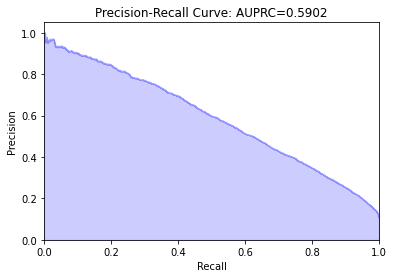

In [17]:
print("LSTM:")
lstm = load_model('critial_disposition_lstm')
probs = lstm.predict(test_data_gen)
result = PlotROCCurve(probs, y_test, ci=confidence_interval, random_seed=random_seed)
results = ["LSTM"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [18]:
# Temporal skip
'''
print("Support Vector Machine:")
from sklearn.svm import SVC
svc=SVC()
start = time.time()
svc.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = svc.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval)

results = ["SVM"]
results.extend(result)
results.append(runtime)
result_list.append(results)
'''

'\nprint("Support Vector Machine:")\nfrom sklearn.svm import SVC\nsvc=SVC()\nstart = time.time()\nsvc.fit(X_train,y_train)\nruntime = time.time()-start\nprint(\'Training time:\', runtime, \'seconds\')\nprobs = svc.predict_proba(X_test)\nresult = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval)\n\nresults = ["SVM"]\nresults.extend(result)\nresults.append(runtime)\nresult_list.append(results)\n'

In [19]:
import numpy as np
def get_score_performance(s):
    print(s)
    score = np.array(df_test[s])
    result = PlotROCCurve(score,y_test, ci=confidence_interval, random_seed=random_seed)
    runtime = 0
    results = [s]
    results.extend(result)
    results.append(runtime)
    result_list.append(results)


ESI
AUC: 0.8038070676582674
AUPRC: 0.1937968667672909
Sensitivity: 0.8698456126636701
Specificity: 0.6400735868794113
Score thresold: -2.0
2.5 97.5


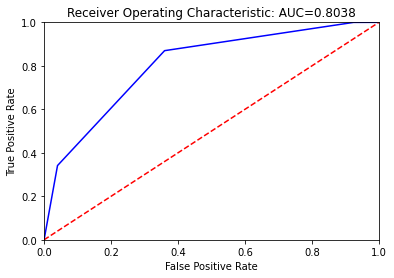

In [20]:
df_test["ESI"] = -df_test["triage_acuity"]
get_score_performance("ESI", random_seed=random_seed)

In [21]:
get_score_performance("score_NEWS", random_seed=random_seed)

score_NEWS
AUC: 0.6341552070549584
AUPRC: 0.14107424569952362
Sensitivity: 0.4637482900136799
Specificity: 0.7954477136364183
Score thresold: 2
2.5 97.5


score_NEWS2
AUC: 0.6164684225054229
AUPRC: 0.12759581535748216
Sensitivity: 0.4103967168262654
Specificity: 0.8225257614197939
Score thresold: 2
2.5 97.5


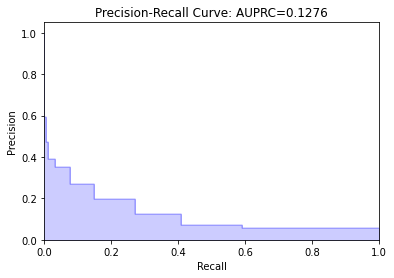

In [22]:
get_score_performance("score_NEWS2", random_seed=random_seed)

score_REMS
AUC: 0.6857535825991775
AUPRC: 0.10537924182262862
Sensitivity: 0.680672268907563
Specificity: 0.6155326030757391
Score thresold: 5
2.5 97.5


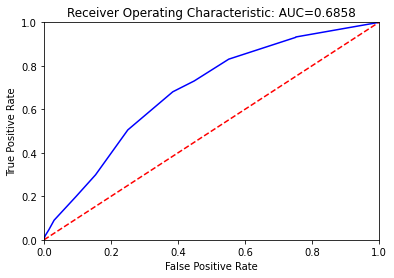

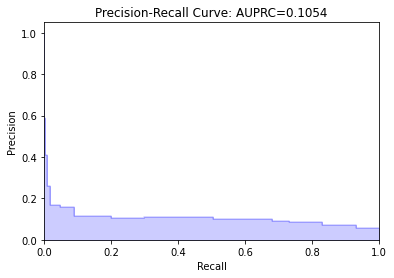

In [23]:
get_score_performance("score_REMS", random_seed=random_seed)

score_MEWS
AUC: 0.6134507698002305
AUPRC: 0.10312450014069556
Sensitivity: 0.43033027164354115
Specificity: 0.7698486178412111
Score thresold: 2
2.5 97.5


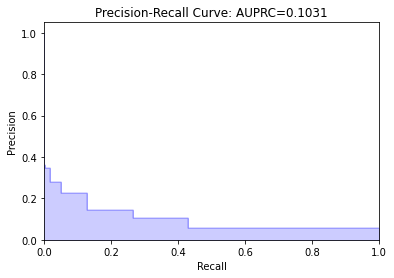

In [24]:
get_score_performance("score_MEWS", random_seed=random_seed)

score_CART
AUC: 0.7072443593699913
AUPRC: 0.14141537005977523
Sensitivity: 0.5896032831737346
Specificity: 0.7306744261546045
Score thresold: 6
2.5 97.5


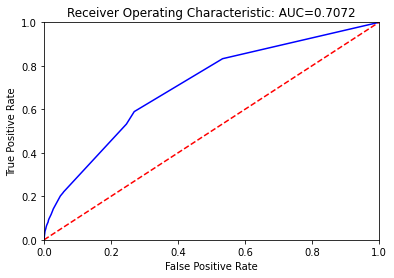

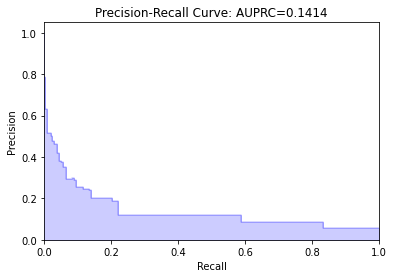

In [25]:
get_score_performance("score_CART", random_seed=random_seed)

### 4. Performance output

In [26]:
#result_df = pd.read_csv(os.path.join(path, 'result_critical_triage.csv'))
result_df = pd.DataFrame(result_list, columns=['Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold', 'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap', 'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity', 'lower_specificity', 'upper_specificity', 'std_specificity', 'runtime'])
result_df.to_csv(os.path.join(path, 'result_critical_disposition.csv'), index=False)
result_df = result_df.round(3)
formatted_result_df = pd.DataFrame()
formatted_result_df[['Model', 'Threshold']] = result_df[['Model', 'threshold']]
formatted_result_df['AUROC'] = result_df['auroc'].astype(str) + ' (' + result_df['lower_auroc'].astype(str) + \
                               '-' + result_df['upper_auroc'].astype(str) + ')'
formatted_result_df['AUPRC'] = result_df['ap'].astype(str) + ' (' + result_df['lower_ap'].astype(str) + \
                               '-' + result_df['upper_ap'].astype(str) + ')'
formatted_result_df['Sensitivity'] = result_df['sensitivity'].astype(str) + ' (' + result_df['lower_sensitivity'].astype(str) + \
                                     '-' + result_df['upper_sensitivity'].astype(str) + ')'
formatted_result_df['Specificity'] = result_df['specificity'].astype(str) + ' (' + result_df['lower_specificity'].astype(str) + \
                                     '-' + result_df['upper_specificity'].astype(str) + ')'
formatted_result_df[['Runtime']] = result_df[['runtime']]
formatted_result_df.to_csv(os.path.join(path, 'task4.csv'), index=False)
formatted_result_df

Model  Threshold                AUROC                AUPRC  \
0            LR      0.059  0.857 (0.854-0.861)  0.346 (0.333-0.359)   
1            RF      0.090   0.932 (0.93-0.935)   0.567 (0.56-0.577)   
2            GB      0.077  0.934 (0.932-0.936)  0.554 (0.546-0.565)   
3           MLP      0.059   0.937 (0.936-0.94)  0.557 (0.551-0.566)   
4          LSTM      0.051  0.945 (0.943-0.947)   0.59 (0.586-0.603)   
5           ESI     -2.000  0.804 (0.799-0.808)  0.194 (0.187-0.201)   
6    score_NEWS      2.000   0.634 (0.627-0.64)  0.141 (0.132-0.147)   
7   score_NEWS2      2.000   0.616 (0.61-0.623)  0.128 (0.121-0.135)   
8    score_REMS      5.000  0.686 (0.682-0.691)   0.105 (0.101-0.11)   
9    score_MEWS      2.000  0.613 (0.608-0.619)  0.103 (0.099-0.109)   
10   score_CART      6.000  0.707 (0.701-0.713)   0.141 (0.135-0.15)   

            Sensitivity          Specificity  Runtime  
0   0.775 (0.765-0.784)   0.78 (0.769-0.784)    7.795  
1   0.876 (0.852-0.879)   0.831 (0.83-0.856)   52.046  
2   0.856 (0.851-0.872)   0.85 (0.837-0.852)   78.797  
3   0.878 (0.864-0.887)  0.839 (0.837-0.849)   78.797  
4   0.876 (0.866-0.892)   0.86 (0.846-0.869)   78.797  
5    0.87 (0.861-0.875)   0.64 (0.637-0.643)    0.000  
6   0.464 (0.452-0.476)  0.795 (0.793-0.798)    0.000  
7    0.41 (0.399-0.592)  0.823 (0.532-0.825)    0.000  
8   0.681 (0.671-0.689)  0.616 (0.613-0.618)    0.000  
9    0.43 (0.419-0.438)   0.77 (0.768-0.772)    0.000  
10   0.59 (0.576-0.598)  0.731 (0.728-0.733)    0.000

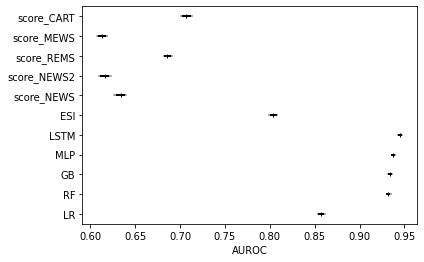

In [27]:
from helpers import plot_confidence_interval
plot_confidence_interval(result_df, metric='auroc', ci=confidence_interval, name = "AUROC", 
                         my_file = 'AUROC_critical.eps', my_path = output_path) 

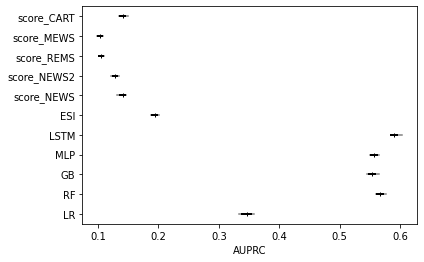

In [28]:
plot_confidence_interval(result_df, metric='ap', ci=confidence_interval, name = "AUPRC", 
                         my_file = 'AUPRC_critical.eps', my_path = output_path)

In [29]:
importance_df = pd.DataFrame(zip(variable, importances), columns=['Variable','Importance'])
importance_df.to_csv(os.path.join(path, 'importances_critical_triage.csv'))
importance_df.sort_values(by='Importance', axis=0,ascending=False)

Variable  Importance
64                        ed_los    0.124008
59             ed_heartrate_last    0.082570
12                 triage_acuity    0.079914
60              ed_resprate_last    0.078573
62                   ed_sbp_last    0.068566
0                            age    0.061949
63                   ed_dbp_last    0.057430
58           ed_temperature_last    0.055815
65                         n_med    0.052826
66                    n_medrecon    0.045901
61                 ed_o2sat_last    0.035093
11                   triage_pain    0.034416
4                      n_ed_365d    0.013581
7                    n_hosp_365d    0.012579
1                         gender    0.010572
10                    n_icu_365d    0.009157
3                       n_ed_90d    0.007651
6                     n_hosp_90d    0.007533
44                      eci_HTN2    0.006410
9                      n_icu_90d    0.005681
40                eci_Arrhythmia    0.005082
32                       cci_DM1    0.005052
51               eci_FluidsLytes    0.005049
28                 cci_Pulmonary    0.004966
2                       n_ed_30d    0.004780
5                     n_hosp_30d    0.004710
13           chiefcom_chest_pain    0.004666
57                eci_Depression    0.004620
24                       cci_CHF    0.004430
14       chiefcom_abdominal_pain    0.004395
48              eci_Coagulopathy    0.004046
45                eci_NeuroOther    0.003950
36                   cci_Cancer1    0.003936
35                     cci_Renal    0.003897
49                   eci_Obesity    0.003842
43                      eci_HTN1    0.003835
46               eci_Hypothyroid    0.003782
26                    cci_Stroke    0.003607
20         chiefcom_fever_chills    0.003577
23                        cci_MI    0.003519
25                       cci_PVD    0.003456
31                    cci_Liver1    0.003447
41                  eci_Valvular    0.003445
33                       cci_DM2    0.003365
54                   eci_Alcohol    0.003350
15             chiefcom_headache    0.003305
50                eci_WeightLoss    0.003292
42                      eci_PHTN    0.003201
53                    eci_Anemia    0.003117
38                   cci_Cancer2    0.002737
8                      n_icu_30d    0.002691
55                     eci_Drugs    0.002604
21              chiefcom_syncope    0.002268
22            chiefcom_dizziness    0.002188
37                    cci_Liver2    0.002150
27                  cci_Dementia    0.002061
30                       cci_PUD    0.001983
34                 cci_Paralysis    0.001910
19      chiefcom_nausea_vomiting    0.001888
29                 cci_Rheumatic    0.001830
18                chiefcom_cough    0.001826
56                 eci_Psychoses    0.001778
52                 eci_BloodLoss    0.001656
17            chiefcom_back_pain    0.001401
47                  eci_Lymphoma    0.001353
16  chiefcom_shortness_of_breath    0.000938
39                       cci_HIV    0.000796